In [30]:
# Import necessary libraries
import os
import math
import tensorflow as tf
import seaborn as sns
import shutil
import numpy as np
import matplotlib.pyplot as plt

from distutils.dir_util import copy_tree
from random import sample
from sklearn.metrics import confusion_matrix, classification_report

Create various directories for model building.

In [12]:
os.mkdir("../train")
os.mkdir("../val")
os.mkdir("best_models")

Assign some paths into a variable.

In [16]:
dataset_path = "../cacao_photos"
images_path = "../train"

Copy the dataset into the train directory.

In [ ]:
copy_tree(dataset_path, images_path)

Create validation folder for each class.

In [17]:
os.mkdir("../val/black_pod_rot")
os.mkdir("../val/healthy")
os.mkdir("../val/pod_borer")

Create a function that moves the specified number of files from lake_path to processed_path.

In [20]:
def move_num_of_files(count, lake_path, processed_path, count_end):
    try:
        images = os.listdir(lake_path)
        for file in images:
            if count < count_end:
                path = f"{lake_path}/{file}"
                shutil.move(path, processed_path)
                count += 1
    except Exception as e:
        print(e)

Move 20% of each class into val directory.

In [22]:
black_pod_20 = math.ceil(len(os.listdir(images_path+"/black_pod_rot")) * 0.20)
healthy_20 = math.ceil(len(os.listdir(images_path+"/healthy")) * 0.20)
pod_borer_20 = math.ceil(len(images_path+"/pod_borer") * 0.20)

move_num_of_files(0, images_path+"/black_pod_rot", "../val/black_pod_rot/", black_pod_20)
move_num_of_files(0, images_path+"/healthy", "../val/healthy/", healthy_20)
move_num_of_files(0, images_path+"/pod_borer", "../val/pod_borer/", pod_borer_20)

# Data Preparation

In [2]:
# Hyperparameters

batch_size = 10
img_height = 224
img_width = 224
class_mode = "sparse"
epochs = 20

In [3]:
train_path = "../train"
val_path = "../val"

Create training and validation sets.

In [4]:
train = tf.keras.utils.image_dataset_from_directory(
    train_path,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=42,
)

val = tf.keras.utils.image_dataset_from_directory(
    val_path,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=42,
    shuffle=False
)

Found 2262 files belonging to 3 classes.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Found 879 files belonging to 3 classes.


2022-12-14 23:09:28.951534: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-14 23:09:28.951900: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Model Building

In [7]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H-%M-%S")
    return os.path.join("./logs", run_id)

In [38]:
base_model = tf.keras.applications.Xception(
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the base model
base_model.trainable = False
for layer in base_model.layers:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
scale_layer = tf.keras.layers.Rescaling(scale=1/255.)(inputs)
x = base_model(scale_layer, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(3, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=[tf.metrics.SparseCategoricalAccuracy()]
                      )

# Callbacks
checkpoint_filepath = "./best_models/lowest_val_loss.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                verbose=1,
                                                save_best_only=True,
                                                )

tensorboard = tf.keras.callbacks.TensorBoard(get_run_logdir())

# Display model summary
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 3)                 6147      
                                                           

In [39]:
history = model.fit(train, epochs=epochs, callbacks=[checkpoint, tensorboard], validation_data=val)

Epoch 1/20


2022-12-15 00:44:01.328515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


227/227 [==============================] - ETA: 0s - loss: 0.6291 - sparse_categorical_accuracy: 0.7352

2022-12-15 00:44:39.909450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.48596, saving model to ./best_models/lowest_val_loss.h5
227/227 [==============================] - 55s 231ms/step - loss: 0.6291 - sparse_categorical_accuracy: 0.7352 - val_loss: 0.4860 - val_sparse_categorical_accuracy: 0.8020
Epoch 2/20
227/227 [==============================] - ETA: 0s - loss: 0.4350 - sparse_categorical_accuracy: 0.8263
Epoch 2: val_loss improved from 0.48596 to 0.41645, saving model to ./best_models/lowest_val_loss.h5
227/227 [==============================] - 53s 231ms/step - loss: 0.4350 - sparse_categorical_accuracy: 0.8263 - val_loss: 0.4165 - val_sparse_categorical_accuracy: 0.8350
Epoch 3/20
227/227 [==============================] - ETA: 0s - loss: 0.3530 - sparse_categorical_accuracy: 0.8678
Epoch 3: val_loss did not improve from 0.41645
227/227 [==============================] - 54s 237ms/step - loss: 0.3530 - sparse_categorical_accuracy: 0.8678 - val_loss: 0.4768 - val_sparse_categorical_accuracy: 0.8055
Epoch 4/

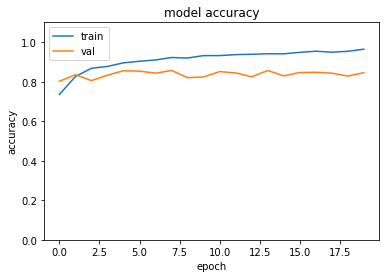

In [40]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylim(top=1.1)
plt.ylim(bottom=0)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

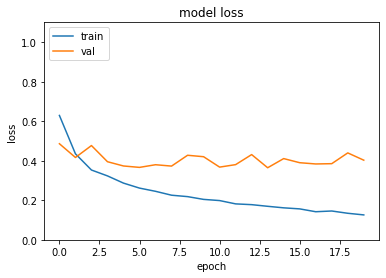

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylim(top=1.1)
plt.ylim(bottom=0)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Making predictions

In [42]:
best_model = tf.keras.models.load_model("./best_models/lowest_val_loss.h5")

In [43]:
val_predictions = best_model.predict(val)

2022-12-15 01:06:43.170499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 16s 169ms/step


In [44]:
labels = []
for _, label in val.as_numpy_iterator():
    for i in label:
        labels.append(i)

preds = []
for pred in val_predictions:
    pred_list = pred.tolist()
    preds.append(pred_list.index(max(pred_list)))

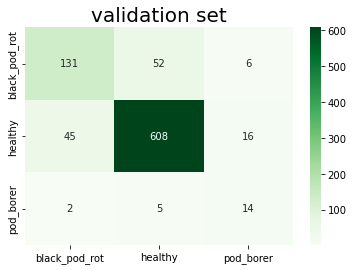

In [46]:
val_cm = confusion_matrix(labels, preds, labels=[0, 1, 2])
val_axis_labels = ["black_pod_rot", "healthy", "pod_borer"]
plt.title("validation set", fontsize=20)
val_ax = sns.heatmap(val_cm, cmap="Greens", annot=True, xticklabels=val_axis_labels, yticklabels=val_axis_labels, fmt="d")

In [47]:
print(classification_report(labels, preds, labels=[0, 1, 2]))

              precision    recall  f1-score   support

           0       0.74      0.69      0.71       189
           1       0.91      0.91      0.91       669
           2       0.39      0.67      0.49        21

    accuracy                           0.86       879
   macro avg       0.68      0.76      0.71       879
weighted avg       0.86      0.86      0.86       879

